# P3.3 - Sequence to Sequence: Text Translation

In this practical we will develop a model for translation of sentences from German to English using the sequence to sequence architecture.

### Learning outcomes
- Understand the basic concepts of a sequence to sequence (seq2seq) model
- How to preprocess textual data.
- How to train a seq2seq model for parametrization of the joint probability distribution $P(y_0, ..., y_k | x_0, ..., x_n)$ over the words $Y$ in the target language, conditioned on the words $X$ of the source sentence.
- How to develop a model for translation of sentences from $P(y_0, ..., y_k | x_0, ..., x_n)$.

**References**
* [1] *Ilya Sutskever, Oriol Vinyals, Quoc V. Le, "Sequence to Sequence Learning with Neural Networks"*, NIPS, 2014. https://arxiv.org/abs/1409.3215

First, some packages to install in Colab. We need to install some old packages for compatibility.


In [1]:
!pip install pytorch-nlp
!python -m spacy download de
!python -m spacy download en
!pip install torch==2.3.0 torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 9.9 MB/s eta 0:00:00
⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 35.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 130.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab noteboo

### Download data

We train a translation model on the multi30K dataset. The dataset was specifically designed for machine translation and evaluation tasks and contains (paired) sentences in English/German.

We will be processing the dataset via the `torchnlp` library. The dataset is then processed in a similar way as in P3.1_rnn_classification. Since the original multi30k download in `torchnlp` is no longer availabe we provide an alternative source.

In [2]:
## boilerplate code to let us download/extract tar.gz downloads ##
import json
from tqdm.notebook import tqdm
import gdown


def download_and_extract(url, file_name):
    gdown.download(url, file_name, quiet=False)
    with open(file_name, 'r', encoding='utf-8') as f:
        data = [json.loads(line.strip()) for line in f]
    return data


train_data = download_and_extract("https://drive.google.com/uc?id=1GqE08tMg-dQBbVRiQZ-7eiEHdjl0LXzr", "train.jsonl")
valid_data = download_and_extract("https://drive.google.com/uc?id=1PIPpx3rm0eYuJw3cJxYpgDlzeIrzeDr9", "test.jsonl")

print(f"Number of training sentences: {len(train_data)}")
print(f"Number of validation sentences: {len(valid_data)}\n\n")

valid_iterator = iter(valid_data)
for _ in range(3):
    batch = next(valid_iterator)
    print("DE: " + batch['de'])
    print("EN: " + batch['en'] + '\n')


Downloading...
From: https://drive.google.com/uc?id=1GqE08tMg-dQBbVRiQZ-7eiEHdjl0LXzr
To: /content/train.jsonl
100%|██████████| 4.60M/4.60M [00:00<00:00, 13.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PIPpx3rm0eYuJw3cJxYpgDlzeIrzeDr9
To: /content/test.jsonl
100%|██████████| 156k/156k [00:00<00:00, 93.1MB/s]

Number of training sentences: 29000
Number of validation sentences: 1000


DE: Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.
EN: A man in an orange hat starring at something.

DE: Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.
EN: A Boston Terrier is running on lush green grass in front of a white fence.

DE: Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt.
EN: A girl in karate uniform breaking a stick with a front kick.



# Preprocessing textual input data

### Create vocabulary
As we have seen in practicals/tutorials P1.2 and P3.2, word embeddings are useful for encoding words into vectors of real numbers. The first step is to build a custom vocabulary from the raw training dataset. To this end, we tokenize each sentence and thereafter count the number of occurances of each token (=word or punctuation mark) in each of the articles using `counter`. Finally, we create the vocabulary by using the frequencies of each token in the counter.

Note that each datapoint consists of a German and English sentence, thus we create seperate tokenizers and vocabularies for both languages. Futhermore, we add special tokens to both vocabularies: $<unk>$ for unknown tokens, $<pad>$ for padding, $<start>$ and $<end>$ as the first and last tokens of each sentence, respectively.

In [3]:
import torch
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
import spacy
from tqdm.notebook import tqdm

# check if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

de_counter, en_counter = Counter(), Counter()

de_tokenizer = get_tokenizer('spacy', language='de')
en_tokenizer = get_tokenizer('spacy', language='en')

for batch in tqdm(train_data):

    en, de = batch.values()

    de_counter.update(de_tokenizer(de))
    en_counter.update(en_tokenizer(en))


de_vocab = vocab(de_counter, min_freq=2, specials=['<unk>', '<start>', '<stop>', '<pad>'])
en_vocab = vocab(en_counter, min_freq=2, specials=['<unk>', '<start>', '<stop>', '<pad>'])

print(f"Unique tokens in source (de) vocabulary: {len(de_vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(en_vocab)}")

/usr/local/lib/python3.11/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

  0%|          | 0/29000 [00:00<?, ?it/s]

Unique tokens in source (de) vocabulary: 8014
Unique tokens in target (en) vocabulary: 6191


### Create pipelines

In the paper we are implementing, they find it beneficial to reverse the order of the input (they believe it "introduces many short term dependencies in the data that make the optimization problem much easier"). We adopt this approach and reverse the German sentence after it has been transformed into a list of tokens.

In [4]:
def de_pipeline(text):
    """
    Reverses German sentence and tokizes from a string into a list of strings (tokens). Then converts each token
    to corresponding indices. Furthermore, it adds a start token at the appropriate position.
    """
    word_idcs = [de_vocab['<start>']]  # start with start token
    vocab_map = de_vocab.get_stoi()  # get our vocab -> idx map

    # now, append all words if they exist in the vocab; if not, enter <unk>
    # note that we do this in reverse
    [word_idcs.append(vocab_map[token] if token in vocab_map else vocab_map['<unk>']) for token in de_tokenizer(text)[::-1]]

    word_idcs.append(de_vocab['<stop>'])  # end with stop token

    return word_idcs

def en_pipeline(text):
    """
    Tokenizes English sentence from a string into a list of strings (tokens), then converts each token
    to corresponding indices. Furthermore, it adds a start token at the appropriate position
    """
    word_idcs = [en_vocab['<start>']]  # start with start token
    vocab_map = en_vocab.get_stoi()  # get our vocab -> idx map

    # now, append all words if they exist in the vocab; if not, enter <unk>
    [word_idcs.append(vocab_map[token] if token in vocab_map else vocab_map['<unk>']) for token in en_tokenizer(text)]
    word_idcs.append(de_vocab['<stop>'])  # end with stop token
    return word_idcs



The pipelines allow us to convert a string sentence into integers:

    en_pipeline('Here is an example!')
    >>> [1, 3071, 35, 205, 0, 2176, 2]

For performance reasons, we tokenize all data up front (rather than doing it per-batch) - in this way, we can directly grab the tokenized sentences while training.

In [5]:
# tokenize all data up front
train_tokenized = [(torch.tensor(en_pipeline(sentence['en']), dtype=torch.int64, device=device),
                    torch.tensor(de_pipeline(sentence['de']), dtype=torch.int64, device=device))
                    for sentence in tqdm(train_data)]
valid_tokenized = [(torch.tensor(en_pipeline(sentence['en']), dtype=torch.int64, device=device),
                   torch.tensor(de_pipeline(sentence['de']), dtype=torch.int64, device=device))
                   for sentence in tqdm(valid_data)]

  0%|          | 0/29000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

### Create DataLoaders
Using the tokenized data we create a `collate_batch` method that produces batches of source and target sentences. The `collate_batch` will be used in the `DataLoader` which enables iterating over the dataset in batches. In each iteration, a batch of source sentences (German) and target sentences (English) should be returned. We use the tokenized data and pad all sequences to create two tensors: one containing the input sentences, and another one for the target sentences.

In [6]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    """
    Concatenate multiple datapoints to obtain a single batch of data
    """
    # sentences are stored as tuples; get respective lists
    en_list = [x[0] for x in batch]
    de_list = [x[1] for x in batch]

    # pad sequences in batch
    de_padded = pad_sequence(sequences = de_list,
                             batch_first = True,
                             padding_value = de_vocab['<pad>'])
    en_padded = pad_sequence(sequences = en_list,
                             batch_first = True,
                             padding_value = en_vocab['<pad>'])

    # return source (DE) and target sequences (EN) after transferring them to GPU (if available)
    return de_padded.to(device).T, en_padded.to(device).T



# Building the Seq2Seq translation model

In the implementation we define three objects: the encoder, the decoder and a full translation model that encapsulates the encoder and decoder. The given code also proposes the main hyperparameters that your implementation should use. Feel free to change the values of these parameters!

The referenced paper uses a 4-layer LSTM, but in the interest of training time we can reduce this to 2-layers.

## Encoder

The encoder takes as input a (batch of) German sentence(s). We already converted all sentences into a zero-padded 2D matrix (shape batch_size, max_seq_len)) containing the tokens that make up the sequences. As output, we want the hidden state to be used as initial state for the Decoder model.

**Exercise**:
Complete the Encoder's class. In the `__init__(self)` you should declare the approriate layers, where `forward(self, src)` declares the forward pass. The encoder should return a compact representation of the input sequence.

In [7]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, source_vocab, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()


        self.source_vocab = source_vocab
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        ### Your code here ###
        self.embedding = nn.Embedding(len(source_vocab), emb_dim)

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

        self.dropout = nn.Dropout(dropout)


    def forward(self, src):
        """
        Forward pass of encoder model. It aims at
        transforming the input sentence to a dense vector

        Input:
        src shape:  [max_seq_len_in_batch, batch_size]

        Output:
        hidden and cell dense vectors (hidden and cell)
        which contains all sentence information, shape [n layers, batch size, hid dim]
        """

        ### Your code here ###
        #src = [src len, batch size]

        embedded = self.dropout(self.embedding(src))
        #embedded = [src len, batch size, emb dim]

        _, (hidden, cell) = self.rnn(embedded)

        return hidden, cell

### Decoder

**Exercise**

The next step is to implement the decoder. The Decoder class aims at performing a single step of decoding, i.e. it outputs a single token per time-step. In the first decoding step, the decoder's hidden state is initialized with that of the encoder, and it takes as input the start token (<<l>start>). Then, it should update the cell and hidden state and predict the first real word (i.e. $s_2$ -- not the <<l>start> token) of the target sentence.

Generally, in a decoder step, we receive the hidden state from the previous time-step, $(h_{t-1}, c_{t-1})$, and update it with the current embedded token, $y_t$, as input (i.e the embedding that of the token predicted at the end of the previous step). We produce a new hidden state, $(h_t, c_t)$, and predict the next token in the sentence.

In [8]:
class Decoder(nn.Module):
    def __init__(self, target_vocab, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.target_vocab = target_vocab
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        ### Your code here ###
        self.embedding = nn.Embedding(len(target_vocab), emb_dim)

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

        self.fc_out = nn.Linear(hid_dim, len(target_vocab))

        self.dropout = nn.Dropout(dropout)


    def forward(self, input, hidden, cell):
        """
        Forward pass of the decoder model. It aims at transforming
        the dense representation of the encoder into a sentence in
        the target language

        Input:
        hidden shape: [n layers, batch size, hid dim]
        cell shape: [n layers, batch size, hid dim]
        input shape: [batch size]  # 1 token for each sentence in the batch

        Output:
        prediction shape: [batch size, num_words_target_vocabulary]
        hidden shape: [n layers, batch size, hid dim]
        cell shape: [n layers, batch size, hid dim]
        """

        ### Your code here ###
        # pytorch expects a sequence, but we use batches with 1 element, i.e., sequence length 1
        input = input.unsqueeze(0)
        #input = [1, batch size]

        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]

        #
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        #output = [1, batch size, hid dim]

        prediction = self.fc_out(output.squeeze(0))  # squeeze our 'sequence length 1' away
        #prediction = [batch size, output dim]

        return prediction, hidden, cell

## The seq2seq model

**Exercise**

The Seq2Seq model takes in an Encoder, Decoder, and a device (used to place tensors on the GPU, if it exists).
For this implementation, we you have to ensure that the number of layers and the hidden (and cell) dimensions are equal in the Encoder and Decoder.

Start with declaring the optimizer and loss function of the model. The loss function should not penalize if the ground truth token is the <<l>pad> token. Use the `ignore_index` input argument of the loss function to realize this behavior.


The forward method takes the source sentence, target sentence and a teacher-forcing ratio. The teacher forcing ratio is used when training our model. When decoding, at each time-step the decoder will predict what the next token in the target sequence will be from the previous tokens decoded, $\hat{y}_{t+1}=f(s_t)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability (1 - `teacher_forcing_ratio`), your model should use the token that the LSTM predicted at the end of the previous step, even if it doesn't match the actual next token in the sequence. The `random.random()` will be useful here.

    

In [9]:
import torch.optim as optim
import random

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        ### Your code here ###
        self.optimizer = optim.Adam(self.parameters())

        TRG_PAD_IDX = en_vocab.get_stoi()['<pad>']
        self.criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        """
        Forward pass of the seq2seq model. It encodes the source sentence into
        a dense representation and thereafter transduces into the target
        sentence.

        Inputs:
        src: padded index representation of source sentences with shape [src len, batch size]
        trg:  padded index representation of target sentences with shape [trg len, batch size]
        teacher_forcing_ratio: probability to use teacher forcing, e.g. 0.5 we use ground-truth target sentence 50% of the time

        Outputs:
        outputs: padded index representation of the predicted sentences with shape [trg_len, batch_size, trg_vocab_size]
        """

        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = len(self.decoder.target_vocab)

        ### Your code here ###
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)

        #first input to the decoder is the <sos> tokens
        input = trg[0]
        for t in range(1, trg_len):
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from our predictions
            top1 = output.argmax(1)

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        return outputs

## Training

**Exercise**

Write functions for training and evaluating your model. You should iterate over the dataset and update the weights of the networks with the computed loss value. Print the value of training and validation loss at the end of each epoch.

Next, you will need to call your `seq2seq` model and train it using the functions that you implemented. Finally, make a plot of the training and validation accuracy.
        
Don't forget to declare `best_valid_loss` at the top of the cell, e.g. with

    best_valid_loss = float('inf')
    
To avoid exploding gradients, you can also use gradient clipping, e.g. with

    torch.nn.utils.clip_grad_norm_(seq2seq.parameters(), clip)

    
Finally, the GPU memory will gradually increase which eventually triggers a memory error. Make sure to clear the GPU memory before running the forward pass using the `torch.cuda.empty_cache()` command.

In [10]:
BATCH_SIZE = 128
N_EPOCHS = 15
CLIP = 1
DROPOUT = 0.5
N_LAYERS = 2 #paper uses 4

EMB_DIM = 256  #dimension of the word embedding
HIDDEN_DIM = 512 #dimension of the lstm's hidden state

In [11]:
# initiate seq2seq translation model
enc = Encoder(de_vocab, EMB_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
dec = Decoder(en_vocab, EMB_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)

seq2seq = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

seq2seq.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (source_vocab): Vocab()
    (embedding): Embedding(8014, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (target_vocab): Vocab()
    (embedding): Embedding(6191, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=6191, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (criterion): CrossEntropyLoss()
)

In [12]:
import time

def train(dataset, clip=CLIP):
    epoch_loss = 0
    seq2seq.train()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)

    ### Your code here ###
    for i, (src, trg) in enumerate(tqdm(dataloader)):

        seq2seq.optimizer.zero_grad()

        output = seq2seq(src, trg)

        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]

        output_dim = output.shape[-1]

        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

        loss = seq2seq.criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(seq2seq.parameters(), clip)

        seq2seq.optimizer.step()

        epoch_loss += loss.item()

        torch.cuda.empty_cache()

    return epoch_loss / len(dataloader)


def evaluate(dataset):
    epoch_loss = 0
    seq2seq.eval()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)

    ### Your code here ###
    with torch.no_grad():

        for i, (src, trg) in enumerate(dataloader):

            output = seq2seq(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]

            output = output[1:].reshape(-1, output_dim)
            trg = trg[1:].reshape(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = seq2seq.criterion(output, trg)

            epoch_loss += loss.item()

            torch.cuda.empty_cache()

    return epoch_loss / len(dataloader)


best_valid_loss = float('inf')
train_loss_arr = []; val_loss_arr = []
for epoch in range(N_EPOCHS):

    epoch_start_time = time.time()

    train_loss = train(train_tokenized)
    val_loss = evaluate(valid_tokenized)

    train_loss_arr.append(train_loss); val_loss_arr.append(val_loss)

    if val_loss < best_valid_loss:
        best_val_loss = val_loss
        torch.save(seq2seq.state_dict(), 'p3_3-model.pt')

    print('-' * 76)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'valid loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           train_loss_arr[-1],
                                           val_loss_arr[-1]))
    print('-' * 76)

  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   0 | time: 49.62s | train loss    5.067 valid loss    5.047 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   1 | time: 49.37s | train loss    4.516 valid loss    4.822 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   2 | time: 50.27s | train loss    4.180 valid loss    4.663 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   3 | time: 49.82s | train loss    4.002 valid loss    4.515 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   4 | time: 49.95s | train loss    3.838 valid loss    4.377 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   5 | time: 49.94s | train loss    3.705 valid loss    4.311 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   6 | time: 49.87s | train loss    3.597 valid loss    4.288 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   7 | time: 50.05s | train loss    3.481 valid loss    4.139 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   8 | time: 49.99s | train loss    3.340 valid loss    4.090 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   9 | time: 50.24s | train loss    3.224 valid loss    4.047 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch  10 | time: 49.88s | train loss    3.116 valid loss    4.006 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch  11 | time: 50.01s | train loss    2.998 valid loss    3.991 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch  12 | time: 49.90s | train loss    2.932 valid loss    3.898 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch  13 | time: 50.00s | train loss    2.834 valid loss    3.979 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch  14 | time: 49.87s | train loss    2.762 valid loss    3.850 
----------------------------------------------------------------------------


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Text(0, 0.5, 'Accuracy')

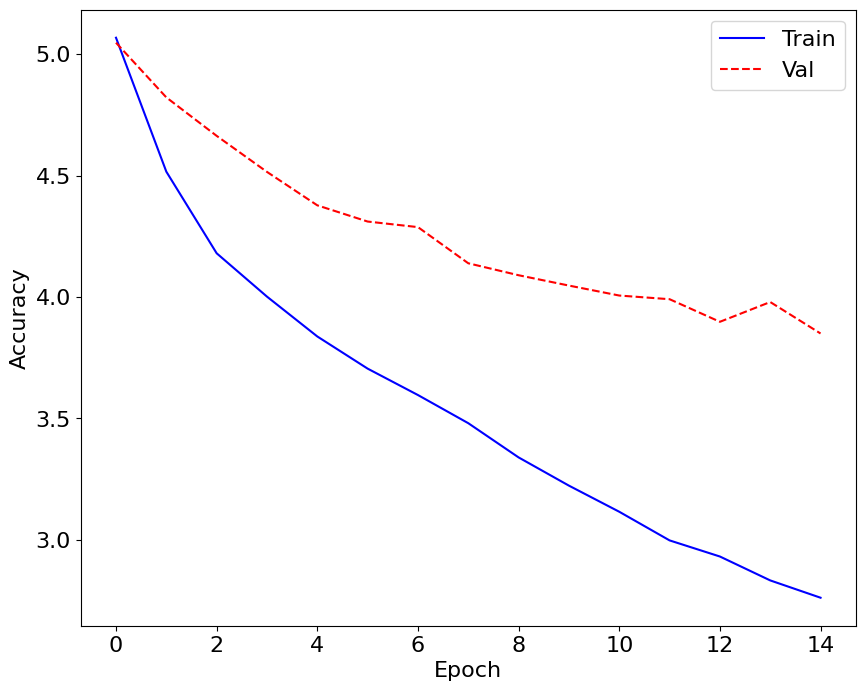

In [13]:
### Plot the training/validation accuracy vs. epochs ###
%pylab inline
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(10,8))

fnt=16
ax.plot(train_loss_arr, color='blue', label='Train')
ax.plot(val_loss_arr, color='red', linestyle='--', label='Val')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)

ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Accuracy", fontsize=fnt)

# Inference

The trained model parametrizes the joint probability distribution $P(Y|X)$ of an English target sentence $Y$ that is a correct translation of the German source sentence $X$. Formally, we seek the sentence $Y$ which maximizes $P(Y|X)$, i.e.

$$
Y = \underset{Y^{'}}{\operatorname{argmax}} p(Y^{′}|X).
$$

**Exercise**

During inference using the seq2seq model you can make certain assumptions that should affect your implementation choices. You can assume conditional independence of the targets $P(Y|X)=P(y_{0:k}|X)=P(y_0|X)P(y_1|X)...P(y_k|X)$. In this case you can implement a greedy decoder that computes the most likely output at each step without taking into acount the selected outputs at previous steps. Or you can implement an autoregressive decoder that computes the joint probability of the output given the input $P(Y|X)=P(y_{0:k}|X)=P(y_0|X)P(y_1|y_0, X)...P(y_k|y_{0:k-1},X)$.


In [14]:
### Your code here ###
def idx_to_sen(sentence_idcs, vocab):
    sentence_idcs = sentence_idcs[sentence_idcs > 3] #remove special tokens
    sentence_idcs = np.array(vocab.get_itos())[sentence_idcs]
    return ' '.join(sentence_idcs)

def print_val_examples(src, trg, pred, N):
    for src_, trg_, pred_ in zip(src[:N], trg[:N], pred[:N]):
        print(f' src: {src_}\n trg: {trg_}\n pred: {pred_}\n')

def greedy_decoder(dataset):

    seq2seq.eval()

    epoch_loss = 0

    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)
    predf = []; srcf = []; trgf = []

    with torch.no_grad():

        for i, (src, trg) in enumerate(dataloader):
            output = seq2seq(src, trg, 0) # no teacher forcing during inference
            top1 = output.argmax(2)

            for p, s, t in zip(top1.T.cpu(), src.T.cpu(), trg.T.cpu()):
                predf.append(idx_to_sen(p, en_vocab))
                srcf.append(idx_to_sen(torch.flip(s, (0, )), de_vocab))
                trgf.append(idx_to_sen(t, en_vocab))

        return srcf, trgf, predf

out = greedy_decoder(valid_tokenized)

print_val_examples(*out, N=10)

 src: Ein Mann mit einem orangefarbenen Hut , der etwas .
 trg: A man in an orange hat starring at something .
 pred: A man in a blue hat is grilling food .

 src: Ein Boston Terrier läuft über Gras vor einem weißen Zaun .
 trg: A Boston Terrier is running on lush green grass in front of a white fence .
 pred: A male car is jumping down a a in front of a white . .

 src: Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt .
 trg: A girl in karate uniform breaking a stick with a front kick .
 pred: A girl in a winter uniform is a a a a .

 src: Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit im Hintergrund .
 trg: Five people wearing winter jackets and helmets stand in the snow , with in the background .
 pred: Five people in red and helmets are in a with with trees in background . background . background .

 src: Leute das Dach eines Hauses .
 trg: People are fixing the roof of a house .
 pred: People are on on a a building .

 src: Ein hell gekleideter Man